In [3]:
import math, pandas, timeit, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.special as scp
from scipy.optimize import curve_fit
from tabulate import tabulate
from numba import njit
import seaborn as sns
sns.set()

# Raport 1.

__Nazwa kursu:__ Symulacje komputerowe

__Prowadzący:__ dr Jakub Ślęzak

__Autorzy:__ Wojciech Gromski, Jakub Antczak

__Rok akademicki:__ 2022/23


# Wstęp

Raport pierwszy skupia się na generowaniu zmiennych losowych poprzez ogólne algorytmy zaprezentowane na zajęciach. Skupimy się tylko i wyłącznie na rozkładach ciągłych lub dyskretnych. Przykłady wygenerowaliśmy w języku *Python*. 

Wszystkie informacje wykorzystane w raporcie były przedstawione na wykładach prof. dr. hab. inż. Marcina Magdziarza.

# Zadanie 1.

Generator MRG32k3a to jedna z metod generowania liczb pseudolosowych. Generator ten jest oparty na generatorze LCG (Linear Congruential Generator). W odróżnieniu od innych generatorów, MRG32k3a zapewnia dobrą jakość generowania liczb pseudolosowych. Reguła rekurencyjna tego generatora to:

$m_1=2^{32}-209$

$m_2=2^{32}-22853$

$X_k=(1403580X_{k-2}-810728X_{k-3})\mod m_1$

$Y_k=(527612Y_{k-1}-1370589Y_{k-3})\mod m_2$

$U_k=\begin{cases}
    \frac{X_k-Y_k+m_1}{m_1+1}, & \quad X_k \leq Y_k\\
    \frac{X_k-Y_k}{m_1+1}, & \quad X_k > Y_k.
    \end{cases}$



### Implementacja

In [4]:
def MRG32K3A_generator(n):
    """n(int): długość wektora
    Funkcja przyjmuje na wejściu długośc wektora, a następnie używając aglorytmu MRG32K3A generuje liczby pseudolosowe.
    Funkcja zwraca wektor o długości n z liczbami z przedziału (0,1)."""
    seedx = np.array([1,2,3])
    seedy = np.array([1,2,3])
    u=np.zeros(n)
    m1=4294967087
    m2=4294944443

    for i in range(n):
        xi=(1403580*seedx[1] - 810728*seedx[0]) % m1
        yi=(527612*seedy[2] - 1370589*seedy[0]) % m2

        u[i]=np.where(xi>yi,(xi-yi)/(m1+1),(xi-yi+m1)/(m1+1))
        
        x3,x2,x1=seedx[1],seedx[2],xi
        y3,y2,y1=seedy[1],seedy[2],yi
        seedx=np.array([x3,x2,x1])
        seedy=np.array([y3,y2,y1])
    
    return u

In [5]:
samples_mrg=MRG32K3A_generator(10**4)

In [6]:
samples_u=np.random.uniform(size=10**4)

### Porównanie histogramów

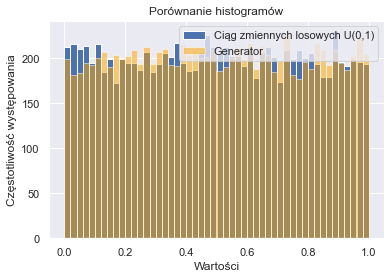

In [7]:
plt.hist(samples_u, bins=50, label="Ciąg zmiennych losowych U(0,1)")
plt.hist(samples_mrg, bins=50, alpha=0.5, color='orange', label="Generator")
plt.title("Porównanie histogramów")
plt.ylabel("Częstotliwość występowania")
plt.xlabel("Wartości")
plt.legend()
plt.show()

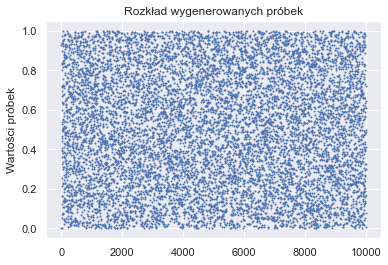

In [8]:
x=np.linspace(0,10**4,10**4)
plt.scatter(x,samples_mrg,s=1)
plt.title("Rozkład wygenerowanych próbek")
plt.ylabel("Wartości próbek")
plt.show()

### Test chi-kwadrat Pearsona

In [9]:
hist, bins_edges=np.histogram(samples_mrg,bins=20,range=(0,1))
observed=hist
expected=np.ones(20)*len(samples_mrg)/20

p_value=stats.chisquare(observed,expected)[1]

### Test Kołmogorowa-Smirnowa

In [10]:
theoretical_cdf=np.linspace(0,1,num=10**4)
p_value_kstest=stats.kstest(samples_mrg,theoretical_cdf)[1]

In [11]:
#tabelka

headers = ["Test", "Wartość"]
data = [
    ["Chi-kwadrat Pearsona:", f"{p_value:.2f}"],
    ["Kołmogorowa-Smirnowa:", f"{p_value_kstest:.2f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒═══════════════════════╤═══════════╕
│ Test                  │   Wartość │
╞═══════════════════════╪═══════════╡
│ Chi-kwadrat Pearsona: │      0.88 │
├───────────────────────┼───────────┤
│ Kołmogorowa-Smirnowa: │      0.99 │
╘═══════════════════════╧═══════════╛


##  Wnioski

Z zaimplementowanego przez nas algorytmu, wynika, że jest on dosyć dobrym przedstawicielem generatora liczb pseudolosowych. Z testu chi-kwadrat, otrzymaliśmy, że wartość p, to około $0.88$, co potwierdza, że wynik wiernie naśladuje niezależny ciąg zmiennych losowych o rozkładzie $U(0,1)$, również w teście Kołmogorowa-Smirnowa wartość p wynosi $0.99$. W obu przypadkach wartość $p$ jest większa od $0.05$, co świadczy o tym, że nasza hipoteza zerowa (próbki pochodzą z rozkładu jednostajnego) nie została odrzucona. Z wykresu punktowego, widać, że rozkład jest zbliżony do $U(0,1)$.

# Zadanie 2.

W tym zadaniu za pomocą metody akceptacji-odrzucenia wygenerujemy rozkład Poissona, używając rozkładu geometrycznego.

Chcemy wygenerować $X \sim P(\lambda)$, $p_k=\frac{\lambda^k}{k!}e^{-\lambda}$ dla $k=0,1\dots$

Niech $Y \sim Geo(p)$, $q_k=p(1-p)^k$ dla $k=1,2\dots$

Wiemy, że istnieje stała $c$ taka, że $\max\limits_{k}(\frac{p_k}{q_k}) \leq C$

1. Wygenerujemy $Y$.
2. Wygenerujemy $U \sim U(0,1)$, $U$ i $Y$ są niezależnymi zmiennymi losowymi.
2. Jeśli $ U \leq \frac{p_k}{Cq_k}$ zwrócimy $X=Y$, w przeciwnym razie wracamy do 1.

### Implementacja

In [12]:
def acceptance(n, lam, p):
    """n(int): liczba próbek, lam(float): parametr rozkładu Poissona, p(float): parametru rozkładu geometrycznego
    Funkcja generuje rozkład Poissona za pomocą metody akceptacji-odrzucenia.
    Funkcja zwraca: samples(numpy.ndarray): wektor z próbkami, accepted(int): ilość zaakceptowanych próbek, rejected(int): ilość odrzuconych próbek"""
    samples=np.zeros(n)
    accepted=0
    rejected=0
    C = np.max([np.exp(-lam)*lam**i/math.factorial(i)/((1-p)**(i-1) * p) for i in range(1, 100)])
    
    while accepted<n:
        y=np.random.geometric(p)
        u=np.random.uniform(0,1)

        if u<= (1/C)*(np.exp(-lam)*lam**y/math.factorial(y))/((1 - p)**(y - 1)*p):
            samples[accepted]=y
            accepted+=1
        else:
            rejected+=1
    
    return samples, accepted, rejected

In [13]:
samples_poisson,accepted,rejected=acceptance(10**4,5,0.5)

### Porównanie dystrybuanty teoretycznej z empiryczną

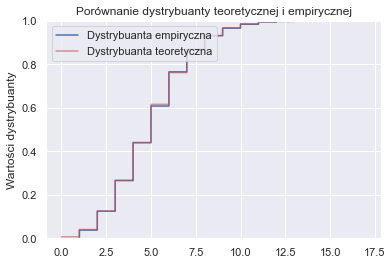

In [14]:
sns.ecdfplot(samples_poisson, label='Dystrybuanta empiryczna')
x=np.linspace(0,max(samples_poisson),10**4)
F=stats.poisson.cdf(x,5)
plt.plot(x,F,'r', alpha=0.6, label='Dystrybuanta teoretyczna')
plt.legend(loc='upper left')
plt.title('Porównanie dystrybuanty teoretycznej i empirycznej')
plt.ylabel('Wartości dystrybuanty')
plt.show()

### Porównanie momentów empirycznych z momentami teoretycznymi

Wartość oczekiwana i wariancja dla $\lambda=5$ rozkładu Poissona wynoszą odpowiednio:

1. $EX = 5$

2. $D^2X = 5$

In [15]:
np.mean(samples_poisson)

5.0155

In [16]:
np.var(samples_poisson)

4.967459749999999

### Efektywność symulacji

#### Metoda odwrotnej dystrybuanty

W celu sprawdzenia efektywności symulacji, porównamy ją z metodą odwrotnej dystrybuanty.

$P(X=x_i)=p_i$ dla $i=1,\dots,n$

$P(X\leq x)=F_x(x)$

Algorytm

1. Generuj $U(0,1)$
2. Wyznacz $j \in \{1,2,\dots,n\}$ takie, że

$\sum_{i=1}^{j-1}p_i < U \leq \sum_{i=1}^{j}p_i \iff F_x(x_{j-1}) < U \leq F_x(x_j)$

3. Zwróć $X=x_j$

In [17]:
def inv_poisson(l,n):
    """l(float): parametru rozkładu Poissona, n(int): ilość próbek do wygenerowania
    Funkcja generuje rozkład Poissona metodą odwrotnej dystrybuanty.
    Funkcja zwraca vector(numpy.ndarray): wektor o długości n z próbkami z rozkładu Poissona"""
    vector=np.zeros(n)
    for i in range(n):
        u=np.random.uniform(0,1)
        k=0
        p=math.exp(-l)
        while u>p:
            k+=1
            p+=math.exp(-l)*l**k/math.factorial(k)
        vector[i]=k
    return vector

In [18]:
samples_poi=inv_poisson(5,10**4)

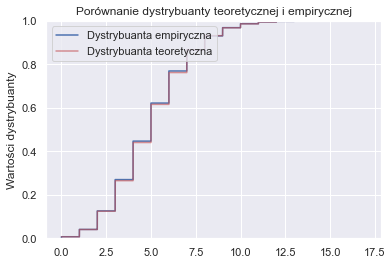

In [19]:
sns.ecdfplot(samples_poi, label='Dystrybuanta empiryczna')
plt.plot(x,F,'r', alpha=0.6, label='Dystrybuanta teoretyczna')
plt.legend(loc='upper left')
plt.title('Porównanie dystrybuanty teoretycznej i empirycznej')
plt.ylabel('Wartości dystrybuanty')
plt.show()

#### Test Kołmogorowa-Smirnowa

In [103]:
samples_poisson_theoretical=np.random.poisson(5,size=10**4)

p_kstest_value_poisson=stats.kstest(samples_poisson,samples_poisson_theoretical)[1]

#tabelka

headers = ["Wartość p testu Kołmogorowa-Smirnowa"]
data = [
    [f"{p_kstest_value_poisson:.5f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒════════════════════════════════════════╕
│   Wartość p testu Kołmogorowa-Smirnowa │
╞════════════════════════════════════════╡
│                                0.83354 │
╘════════════════════════════════════════╛


#### Porównanie czasów dla różnych długości prób

In [105]:
invtime1=timeit.timeit("inv_poisson(5,10**3)", globals=globals(), number=100)/100
accrejtime1=timeit.timeit("acceptance(10**3,5,0.5)", globals=globals(), number=100)/100
invtime2=timeit.timeit("inv_poisson(5,10**5)", globals=globals(), number=10)/10
accrejtime2=timeit.timeit("acceptance(10**5,5,0.5)", globals=globals(), number=10)/10

#tabelka

headers = ["Metoda", "Czas dla 1000 próbek", "Czas dla 100000 próbek"]
data = [
    ["Akceptacji i odrzucenia:", f"{accrejtime1:3f}", f"{accrejtime2:3f}"],
    ["Odwróconej dystrybuanty:", f"{invtime1:3f}", f"{invtime2:3f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)


╒══════════════════════════╤════════════════════════╤══════════════════════════╕
│ Metoda                   │   Czas dla 1000 próbek │   Czas dla 100000 próbek │
╞══════════════════════════╪════════════════════════╪══════════════════════════╡
│ Akceptacji i odrzucenia: │               0.073845 │                 8.04286  │
├──────────────────────────┼────────────────────────┼──────────────────────────┤
│ Odwróconej dystrybuanty: │               0.003729 │                 0.343878 │
╘══════════════════════════╧════════════════════════╧══════════════════════════╛


### Wnioski

Z otrzymanych wyników, widać, że dystrybuanta empiryczna i dystrybuanta teoretyczna w znacznym staniu pokrywają się ze sobą, co może oznaczać, że nasza symulacja jest skuteczną symulacją. Wariancja i wartość oczekiwana próby jest zbliżona do wartości teoretycznej. Z testu Kołmogorowa-Smirnowa, otrzymaliśmy, że wartość p, to około $0.83$, co potwierdza, że wynik wiernie naśladuje niezależny ciąg zmiennych losowych o rozkładzie $P(5)$ Czas wywołania zarówno dla małych prób rozmiaru $10^3$, jak i próby rozmiaru $10^5$, różni się od siebie o rząd wielkości, co oznacza, że metoda akceptacji-odrzucenia nie jest efektywną metodą generowania rozkładu. 

# Zadanie 3.

**Metoda Ziggurata** to algorytm numeryczny służący do generowania zmiennych losowych o rozkładzie normalnym. Algorytm ten jest oparty na technice "próbkowania odrzuceń" (rejection sampling) i polega na przybliżeniu rozkładu normalnego przez zestaw prostokątów. Wartości funkcji g(x) dla każdego z prostokątów są wyznaczane numerycznie, a następnie stosowane są do akceptacji lub odrzucenia wygenerowanych próbek.

Idea metody Ziggurata polega na tym, że dla rozkładu normalnego znane są wartości skumulowanej funkcji gęstości prawdopodobieństwa. W metodzie Ziggurata wykorzystuje się te wartości do wygenerowania zmiennych losowych o rozkładzie normalnym poprzez "próbkowanie" z zestawu prostokątów. W celu wygenerowania zmiennej losowej, najpierw losowana jest zmienna losowa o rozkładzie wykładniczym, a następnie jej wartość jest porównywana z wartością gęstości prawdopodobieństwa na danym przedziale. Jeśli wartość zmiennej losowej jest mniejsza niż wartość gęstości na danym przedziale, to zmienna jest akceptowana, w przeciwnym przypadku jest odrzucana. 

Metoda Ziggurata pozwala na szybkie i efektywne generowanie dużych ilości zmiennych losowych o rozkładzie normalnym.

### Implementacja

Funkcja *ziggurat* generuje n zmiennych losowych o rozkładzie normalnym metodą Ziggurata. Argument *n* to liczba zmiennych losowych do wygenerowania, a *n_przedziałów* to liczba przedziałów używanych do dyskretyzacji funkcji g(x). Funkcja zwraca krotkę zawierającą wygenerowane zmienne losowe o rozkładzie normalnym, *wskaznik_akceptacji* - procentową liczbę zmiennych losowych, które zostały zaakceptowane oraz liczbę obliczeń funkcji wykładniczej użytej do generowania zmiennych losowych.

In [21]:
@njit(fastmath=True)
def f(x):
    """
    Oblicza wartość funkcji gęstości prawdopodobieństwa dla standardowego rozkładu normalnego dla podanej wartości x.

    Argumenty:
        x (float): Wartość, dla której ma być obliczona funkcja gęstości prawdopodobieństwa.

    Zwraca:
        float: Wartość funkcji gęstości prawdopodobieństwa dla standardowego rozkładu normalnego dla podanej wartości x.
    """
    
    return (1 / (np.sqrt(2 * np.pi)) * np.exp(-(x ** 2) / 2))


@njit(fastmath=True)
def g(x):
    """
    Oblicza wartość funkcji gęstości prawdopodobieństwa rozkładu wykładniczego dla podanej wartości x.

    Argumenty:
        x (float): Wartość, dla której ma być obliczona wartość funkcji.

    Zwraca:
        float: Wartość funkcji dla podanej wartości x.
    """
    return np.exp(-(x ** 2) / 2 + x) / (np.sqrt(np.e))


def ziggurat(n, n_przedziałów):
    """
    Generuje n zmiennych losowych o rozkładzie normalnym metodą Ziggurata.

    Argumenty:
    n -- liczba zmiennych losowych do wygenerowania
    n_przedziałów -- liczba przedziałów używanych do dyskretyzacji funkcji g(x)

    Zwraca krotkę zawierającą:
    - numpy array z wygenerowanymi zmiennymi losowymi o rozkładzie normalnym
    - wskaznik_akceptacji -- procentowa liczba zmiennych losowych, które zostały zaakceptowane
    - ilosc_obliczeń_funkcji_wykladniczej -- liczba obliczeń funkcji wykładniczej użytej do generowania
        zmiennych losowych

    """
    przedzialy = np.linspace(0, 20, n_przedziałów)
    wartości_funkcji = g(przedzialy)
    zmienne_rozkladu = np.zeros(n)
    ilosc_wylosowanych_zmiennych = 0
    ilosc_obliczeń_funkcji_wykladniczej = 0
    licznik = 0
    while ilosc_wylosowanych_zmiennych < n:
        zmienna_losowa_U = -np.log(np.random.rand())
        zmienna_losowa_Y = np.random.rand()
        indeks_przedzialu = np.searchsorted(przedzialy, zmienna_losowa_U, side='right') - 1
        if zmienna_losowa_Y <= wartości_funkcji[indeks_przedzialu]:
            znak = np.random.choice([-1, 1])
            zmienne_rozkladu[ilosc_wylosowanych_zmiennych] = znak * zmienna_losowa_U
            ilosc_wylosowanych_zmiennych += 1
        elif indeks_przedzialu == n_przedziałów - 1:
            ilosc_obliczeń_funkcji_wykladniczej += 1
            if zmienna_losowa_Y <= g(zmienna_losowa_U):
                znak = np.random.choice([-1, 1])
                zmienne_rozkladu[ilosc_wylosowanych_zmiennych] = znak * zmienna_losowa_U
                ilosc_wylosowanych_zmiennych += 1
        elif zmienna_losowa_Y <= (wartości_funkcji[indeks_przedzialu+1] - wartości_funkcji[indeks_przedzialu]) \
                                / (przedzialy[indeks_przedzialu+1] - przedzialy[indeks_przedzialu]) \
                                * (zmienna_losowa_U - przedzialy[indeks_przedzialu]) \
                                + wartości_funkcji[indeks_przedzialu]:
            znak = np.random.choice([-1, 1])
            zmienne_rozkladu[ilosc_wylosowanych_zmiennych] = znak * zmienna_losowa_U
            ilosc_wylosowanych_zmiennych += 1
        else:
            ilosc_obliczeń_funkcji_wykladniczej += 1
            if zmienna_losowa_Y <= g(zmienna_losowa_U):
                znak = np.random.choice([-1, 1])
                zmienne_rozkladu[ilosc_wylosowanych_zmiennych] = znak * zmienna_losowa_U
                ilosc_wylosowanych_zmiennych += 1
        licznik += 1
    wskaznik_akceptacji = ilosc_wylosowanych_zmiennych / licznik * 100
    return (zmienne_rozkladu, wskaznik_akceptacji, ilosc_obliczeń_funkcji_wykladniczej)

### Obliczenia

Poniższy kod generuje próbki z rozkładu normalnego z użyciem metody Ziggurata i oblicza wskaźnik akceptacji oraz liczby wywołań funkcji wykładniczej dla różnych ilości podziałów. Następnie wyniki są wyświetlane w formie tabeli, gdzie kolumnami są różne ilości podziałów, a wierszami - wskaźniki akceptacji dla poszczególnych ilości podziałów.

In [109]:
n = 10**5
probki = []
wskazniki = []
liczby_podzialow = (2, 10**2, 250, 500, 750, 10**3, 2500, 5000, 7500, 10**4)
ilosci_wykl = []

for liczba_podzialow in liczby_podzialow:
    prob, wskaznik_akceptacji, ilosc_wykl = ziggurat(n, liczba_podzialow)
    probki.append(prob)
    wskazniki.append(wskaznik_akceptacji)
    ilosci_wykl.append(ilosc_wykl)

headers = ["Liczba podziałow:", "2 podziały", "100 podziałów", "250 podziałów", "500 podziałów", "750 podziałów", "1000 podziałów", "2500 podziałów", "5000 podziałów", "7500 podziałów", "10000 podziałów"]
data = [
    ["Wskaźnik akceptacji:", f"{wskazniki[0]:.2f}%", f"{wskazniki[1]:.2f}%", f"{wskazniki[2]:.2f}%", f"{wskazniki[3]:.2f}%", f"{wskazniki[4]:.2f}%", f"{wskazniki[5]:.2f}%", f"{wskazniki[6]:.2f}%", f"{wskazniki[7]:.2f}%", f"{wskazniki[8]:.2f}%", f"{wskazniki[9]:.2f}%"]]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒══════════════════════╤══════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤═══════════════════╕
│ Liczba podziałow:    │ 2 podziały   │ 100 podziałów   │ 250 podziałów   │ 500 podziałów   │ 750 podziałów   │ 1000 podziałów   │ 2500 podziałów   │ 5000 podziałów   │ 7500 podziałów   │ 10000 podziałów   │
╞══════════════════════╪══════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪═══════════════════╡
│ Wskaźnik akceptacji: │ 80.86%       │ 77.40%          │ 76.47%          │ 76.17%          │ 76.27%          │ 76.19%           │ 76.31%           │ 75.98%           │ 76.11%           │ 76.13%            │
╘══════════════════════╧══════════════╧═════════════════╧═════════════════╧═════════════════╧═════════════════╧══════════════════╧══════════════════╧══════════════════╧

In [117]:
kspvalues=np.zeros(len(probki))
jbpvalues=np.zeros(len(probki))

for i, probka in enumerate(probki):
    kspvalues[i] = stats.kstest(probka,'norm', args=(0,1))[1]
    jbpvalues[i] = stats.jarque_bera(probka)[1]

headers = ["Liczba podziałów:", "2 podziały", "100 podziałów", "250 podziałów", "500 podziałów", "750 podziałów", "1000 podziałów", "2500 podziałów", "5000 podziałów", "7500 podziałów", "10000 podziałów"]
data = [
    ["Test Kołmogorowa-Smirnowa:", f"{kspvalues[0]:.6f}", f"{kspvalues[1]:.6f}", f"{kspvalues[2]:.6f}", f"{kspvalues[3]:.6f}", f"{kspvalues[4]:.6f}", f"{kspvalues[5]:.6f}", f"{kspvalues[6]:.6f}", f"{kspvalues[7]:.6f}", f"{kspvalues[8]:.6f}", f"{kspvalues[9]:.6f}"],
    ["Test Jarque-Bera:", f"{jbpvalues[0]:.6f}", f"{jbpvalues[1]:.6f}", f"{jbpvalues[2]:.6f}", f"{jbpvalues[3]:.6f}", f"{jbpvalues[4]:.6f}", f"{jbpvalues[5]:.6f}", f"{jbpvalues[6]:.6f}", f"{jbpvalues[7]:.6f}", f"{jbpvalues[8]:.6f}", f"{jbpvalues[9]:.6f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒════════════════════════════╤══════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤═══════════════════╕
│ Liczba podziałów:          │   2 podziały │   100 podziałów │   250 podziałów │   500 podziałów │   750 podziałów │   1000 podziałów │   2500 podziałów │   5000 podziałów │   7500 podziałów │   10000 podziałów │
╞════════════════════════════╪══════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════╪═══════════════════╡
│ Test Kołmogorowa-Smirnowa: │            0 │         0.00014 │        0.043312 │        0.284611 │        0.424217 │         0.871091 │         0.934427 │         0.490817 │         0.969889 │          0.796214 │
├────────────────────────────┼──────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼────────

Widać, że od $500$ podziałów wartości $p$ obu testów są akceptowalne (większe niż $0.05$) i nie ma powodów, by odrzucić hipotezy, że próbka pochodzi z rozkładu $N(0,1)$.

### Wizualizacja

Na poniższych wykresach przedstawiliśmy:

- zależność wskaźnika akceptacji od liczby podziałów;
- histogramy dla różnych wyborów wskaźnika akceptacji;
- zależność liczby obliczeń funkcji wykładniczej od liczby podziałów;
- zależność czasu wykonania od liczby podziałów.

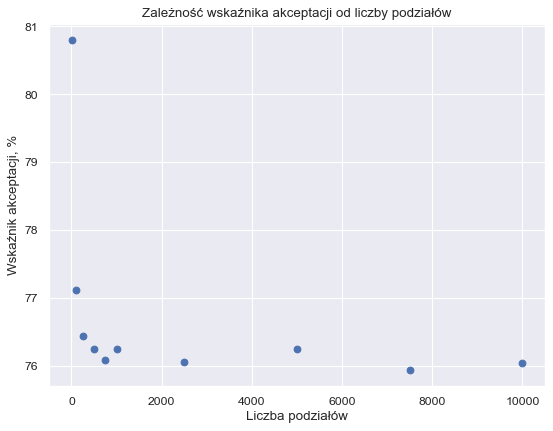

In [23]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(liczby_podzialow, wskazniki)
plt.xlabel("Liczba podziałów")
plt.ylabel("Wskaźnik akceptacji, %")
plt.title("Zależność wskaźnika akceptacji od liczby podziałów")
plt.show()

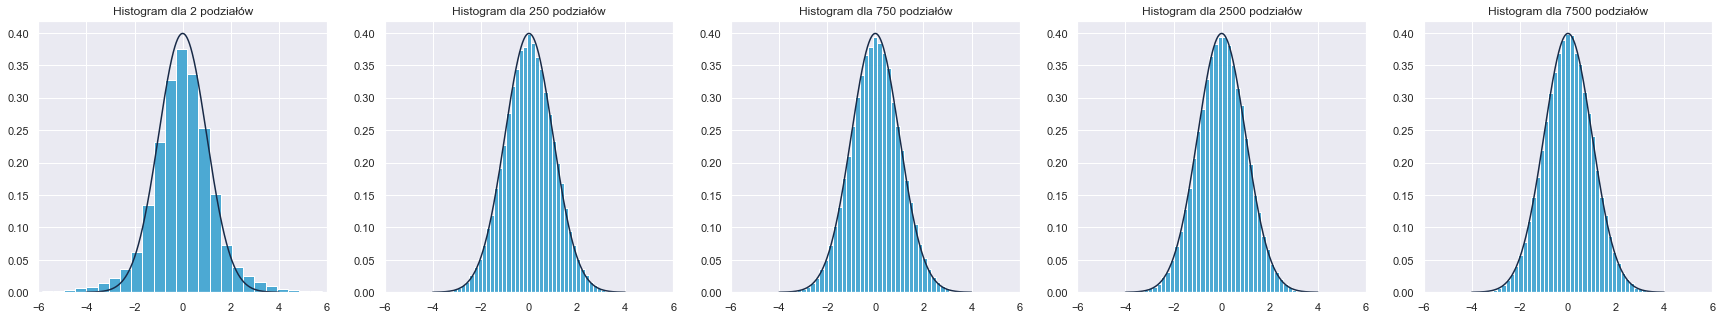

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(30, 5))

x = np.linspace(-4,4,1000)
y = f(x)

for i, podzialy in enumerate(liczby_podzialow[::2]):
    axs[i].hist(probki[i], bins=50, density=True, color="#4ca9d3")
    axs[i].plot(x, y, color="#182a47")
    axs[i].set_title(f"Histogram dla {podzialy} podziałów")
    axs[i].set_xlim(-6,6)
plt.show()

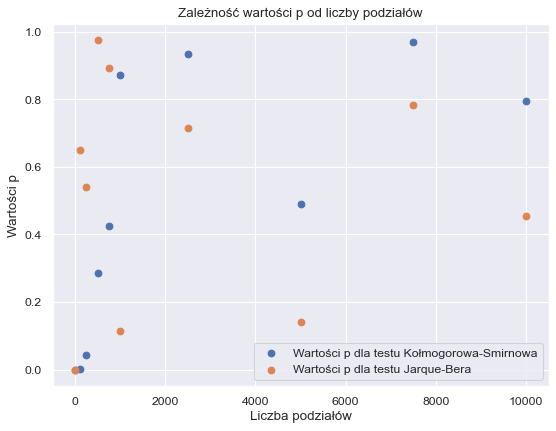

In [122]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(liczby_podzialow, kspvalues, label="Wartości p dla testu Kołmogorowa-Smirnowa")
plt.scatter(liczby_podzialow, jbpvalues, label="Wartości p dla testu Jarque-Bera")
plt.xlabel("Liczba podziałów")
plt.ylabel("Wartości p")
plt.title("Zależność wartości p od liczby podziałów")
plt.legend()
plt.show()

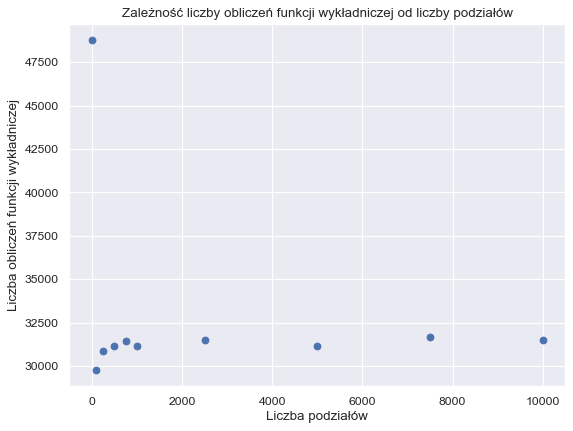

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(liczby_podzialow, ilosci_wykl)
plt.xlabel("Liczba podziałów")
plt.ylabel("Liczba obliczeń funkcji wykładniczej")
plt.title("Zależność liczby obliczeń funkcji wykładniczej od liczby podziałów")
plt.show()

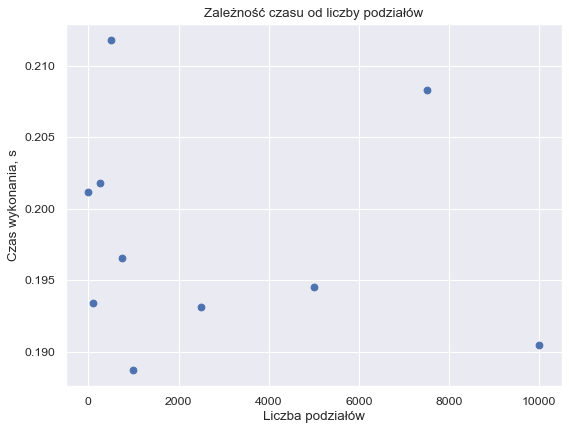

In [26]:
times = []

for podzialy in liczby_podzialow:
    times.append(timeit.timeit("ziggurat(10**4, liczba_podzialow)", globals=globals(), number=100)/100)


plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(liczby_podzialow, times)
plt.xlabel("Liczba podziałów")
plt.ylabel("Czas wykonania, s")
plt.title("Zależność czasu od liczby podziałów")
plt.show()

### Wnioski

Z wygenerowanych wykresów można wyciągnąć następujące wnioski:

- Im większa jest liczba podziałów, tym wskaźnik akceptacji jest mniejszy. Sugeruje to, że im większa liczba przedziałów, na które dzielimy funkcję g(x), tym trudniej jest zaakceptować wylosowaną zmienną losową.
- Z liczbą podziałów rośnie również dokładność generowania rozkładu;
- Z pominięciem wartości odstającej, można również zauważyć tendecję rosnącą liczby wywołań funkcji wykładniczej;
- W przypadku czasów wykonania nie widać oczywistej zależności od liczby podziałów.

W związku z powyższymi wnioskami, dobór liczby przedziałów w metodzie Ziggurata powinien zależeć od zrownoważenia między dokładnością generowania rozkładu, procentem akceptowanych zmiennych oraz czasu wykonania.

# Zadanie 4.

W tym zadaniu wygenerujemy rozkład normalny za pomocą trzech metod - Boxa-Mullera, Marsgalia oraz odwrotnej dystrybuanty, następnie porównamy ich efektywność.

### Metoda Boxa-Mullera

Niech $U_1$, $U_2$ będą niezależnymi zmiennymi losowymi o rozkładzie $U_1\sim U(0,1)$, $U_2\sim U(0,1)$. 
Zdefiniujmy:

$X=\sqrt{-2{\ln{U_1}}} \cos(2\pi U_2)$ 

oraz 

$Y=\sqrt{-2{\ln{U_1}}} \sin(2\pi U_2)$.

Wtedy $X$ i $Y$ są niezależne oraz $X \sim N(0,1)$ oraz $Y \sim N(0,1)$.

#### Implementacja

In [27]:
def box_muller(n):
    """n(int): liczba próbek do wygenerowania
    Funkcja generuje rozkład normalny za pomocą metody Boxa-Mullera.
    Funkcja zwraca x(numpy.ndarray): wektor o długości n z próbkami z rozkładu normalnego, y(numpy.ndarray): wektor o długości n z próbkami z rozkładu normalnego."""
    x=np.zeros(n)
    y=np.zeros(n)

    for i in range(n):
        u1=np.random.random()
        u2=np.random.random()

        r=math.sqrt(-2*math.log(u1))
        theta=2*math.pi*u2

        x[i]=r*math.cos(theta)
        y[i]=theta*math.sin(theta)
    
    return x,y

#### Związek między zmiennymi losowymi X, Y o rozkładach N(0,1)

In [28]:
x_muller=box_muller(10**4)
y_muller=box_muller(10**4)

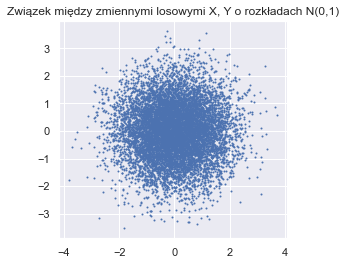

In [29]:
plt.scatter(x_muller[0],y_muller[0],s=1)
plt.title("Związek między zmiennymi losowymi X, Y o rozkładach N(0,1)")
plt.gca().set_aspect('equal')
plt.show()

#### Porównanie gęstości teoretycznej z histogramem

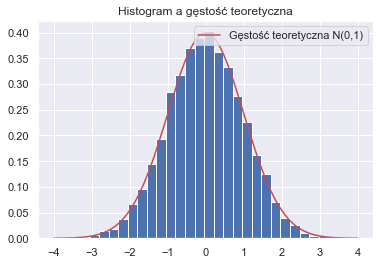

In [30]:
plt.hist(x_muller[0], bins=30, density=True)
x_muller_linspace=np.linspace(-4,4,1000)
F_muller=stats.norm.pdf(x_muller_linspace,0,1)
plt.plot(x_muller_linspace,F_muller, color='r', label='Gęstość teoretyczna N(0,1)')
plt.title('Histogram a gęstość teoretyczna')
plt.legend(loc='upper right')
plt.show()

#### Porównanie dystrybuanty empirycznej z teoretyczną

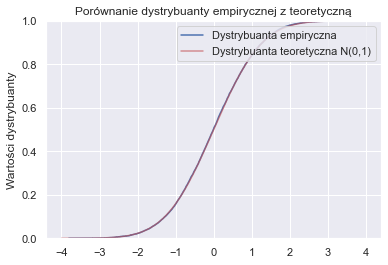

In [31]:
sns.ecdfplot(x_muller[0], label='Dystrybuanta empiryczna')
F_muller_cdf=stats.norm.cdf(x_muller_linspace,0,1)
plt.plot(x_muller_linspace,F_muller_cdf, color='r', alpha=0.6, label='Dystrybuanta teoretyczna N(0,1)')
plt.title('Porównanie dystrybuanty empirycznej z teoretyczną')
plt.legend(loc='upper right')
plt.ylabel('Wartości dystrybuanty')
plt.show()

### Metoda Marsgalia

Generowanie rozkładu normalnego za pomocą metody Boxa-Mullera jest nieefektywne przez funkcję $\sin$ i $\cos$, dlatego pozbędziemy się ich. W tym celu generujemy wektor $(V_1,V_2)$ o rozkładzie jednostajnym w kole jednostkowym.

Niech $V_1=R\cos(\alpha)$, $V_2=R\sin(\alpha)$.

1. Wygeneruj $V_1$, $V_2$ $\sim U(-1,1)$.

2. Wyznacz $R^2=V^2_1 + V^2_2$.

3. Jeśli $R^2>1$, wróć do 1., w przeciwnym razie, wstaw: $X=\sqrt \frac{-2 \ln R^2}{R^2} V_1$ oraz $Y=\sqrt \frac{-2\ln R^2}{R^2} V_2$

Wtedy $X$ i $Y$ są niezależne oraz $X \sim N(0,1)$ oraz $Y \sim N(0,1)$.

#### Implementacja

In [32]:
def marsgalia(n):
    """n(int): liczba próbek do wygenerowania
    Funkcja generuje rozkład normalny za pomocą metody Marsgalii.
    Funkcja zwraca x(numpy.ndarray): wektor o długości n z próbkami z rozkładu normalnego, y(numpy.ndarray): wektor o długości n z próbkami z rozkładu normalnego."""
    X=np.zeros(n)
    Y=np.zeros(n)
    i=0
    while i<n:
        x=np.random.uniform(-1,1)
        y=np.random.uniform(-1,1)
        r2=x**2+y**2
        while r2>1:
            x=np.random.uniform(-1,1)
            y=np.random.uniform(-1,1)
            r2=x**2+y**2
        X[i]=np.sqrt(-2*np.log(r2)/r2)*x
        Y[i]=np.sqrt(-2*np.log(r2)/r2)*y
        i+=1
    return X,Y

In [33]:
x_marsgalia=marsgalia(10**6)
y_marsgalia=marsgalia(10**6)

#### Związek między zmiennymi losowymi X, Y o rozkładach N(0,1)

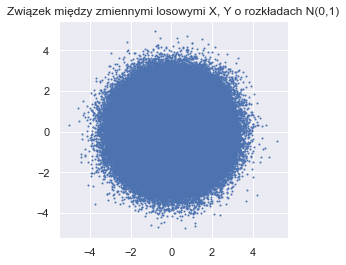

In [34]:
plt.scatter(x_marsgalia[0],y_marsgalia[0],s=1)
plt.title("Związek między zmiennymi losowymi X, Y o rozkładach N(0,1)")
plt.gca().set_aspect('equal')
plt.show()

#### Porównanie histogramu z gęstością teoretyczną

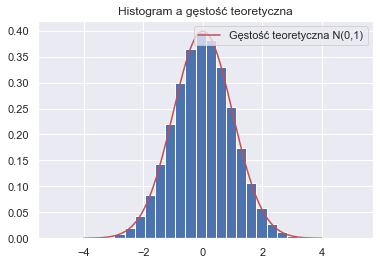

In [35]:
plt.hist(x_marsgalia[0], density=True, bins=30)
x_linspace=np.linspace(-4,4,1000)
F=stats.norm.pdf(x_linspace,0,1)
plt.plot(x_linspace,F, color='r', label='Gęstość teoretyczna N(0,1)')
plt.legend(loc='upper right')
plt.title('Histogram a gęstość teoretyczna')
plt.show()

#### Porównanie dystrybuanty empirycznej z teoretyczną

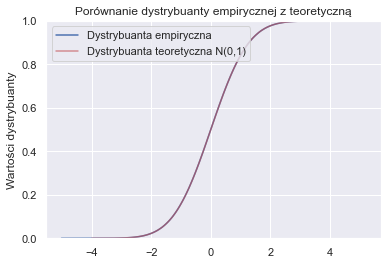

In [36]:
sns.ecdfplot(x_marsgalia[0], label='Dystrybuanta empiryczna')
F_cdf=stats.norm.cdf(x_linspace,0,1)
plt.plot(x_linspace,F_cdf, color='r', alpha=0.6, label='Dystrybuanta teoretyczna N(0,1)')
plt.legend(loc='upper left')
plt.title('Porównanie dystrybuanty empirycznej z teoretyczną')
plt.ylabel('Wartości dystrybuanty')
plt.show()

### Metoda odwrotnej dystrybuanty

Chcemy wygenerować zmienną losową $X$ o dystrybuancie $F_x(x)$

1. Wyznaczmy $F_x^{-1}(x)$

2. Generujmy $U \sim U(0,1) $

3. Wstaw $X=F_x^{-1}(U)$

W ten sposób wygenerujemy rozkład normalny.

#### Implementacja

In [37]:
def inv_normal(m,s,n):
    """ m(float): wartość oczekiwana rozkładu normalnego
    s(float): odchylenie standardowe rozkładu normalnego
    n(int): długość próby
    Funkcja generuje n liczb losowych z rozkładu normalnego o podanej m i s, używając metody odwrotnej dystrybuanty. """
    u=np.random.uniform(0,1,n)
    return np.sqrt(2)*s*scp.erfinv(2*u-1)+m

In [38]:
normal_inv_samples=inv_normal(0,1,10**6)

#### Porównanie histogramu z gęstością teoretyczną

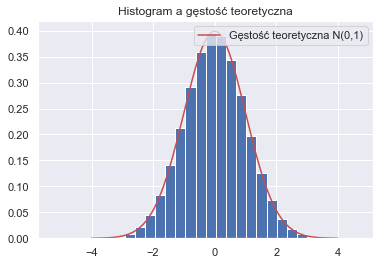

In [39]:
plt.hist(normal_inv_samples, density=True, bins=30)
plt.plot(x_linspace,F, color='r', label='Gęstość teoretyczna N(0,1)')
plt.legend(loc='upper right')
plt.title('Histogram a gęstość teoretyczna')
plt.show()

#### Porównanie dystrybuanty empirycznej z dystrybuantą teoretyczną.

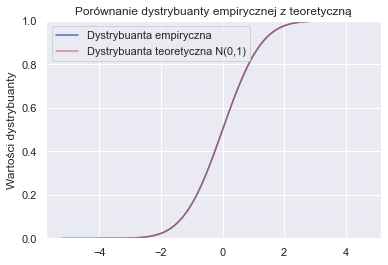

In [40]:
sns.ecdfplot(normal_inv_samples, label='Dystrybuanta empiryczna')
plt.plot(x_linspace,F_cdf, color='r', alpha=0.6, label='Dystrybuanta teoretyczna N(0,1)')
plt.legend(loc='upper left')
plt.title('Porównanie dystrybuanty empirycznej z teoretyczną')
plt.ylabel('Wartości dystrybuanty')
plt.show()

### Efektywność symulacji

#### Test Kołmogorowa-Smirnowa

In [41]:
p_value_kstest_normal_muller=stats.kstest(x_muller[0],'norm', args=(0,1))[1]
p_value_kstest_normal=stats.kstest(x_marsgalia[0],'norm', args=(0,1))[1]
p_value_kstest_normal_inv=stats.kstest(normal_inv_samples,'norm', args=(0,1))[1]

#### Test Jarque-Bera

In [42]:
p_value_jarque_bera_normal_muller=stats.jarque_bera(x_muller[0])[1]
p_value_jarque_bera_normal=stats.jarque_bera(x_marsgalia[0])[1]
p_value_jarque_bera_normal_inv=stats.jarque_bera(normal_inv_samples)[1]

In [58]:
headers = ["Metoda", "Test Kołmogorowa-Smirnowa", "Test Jarque-Bera"]
data = [
    ["Mullera:", f"{p_value_kstest_normal_muller:.4f}", f"{p_value_jarque_bera_normal_muller:.4f}"],
    ["Marsgalii:", f"{p_value_kstest_normal:.4f}", f"{p_value_jarque_bera_normal:.4f}"],
    ["Odwróconej dystrybuanty:", f"{p_value_kstest_normal_inv:.4f}", f"{p_value_jarque_bera_normal_inv:.4f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒══════════════════════════╤═════════════════════════════╤════════════════════╕
│ Metoda                   │   Test Kołmogorowa-Smirnowa │   Test Jarque-Bera │
╞══════════════════════════╪═════════════════════════════╪════════════════════╡
│ Mullera:                 │                      0.7173 │             0.8657 │
├──────────────────────────┼─────────────────────────────┼────────────────────┤
│ Marsgalii:               │                      0.8896 │             0.3203 │
├──────────────────────────┼─────────────────────────────┼────────────────────┤
│ Odwróconej dystrybuanty: │                      0.6638 │             0.6075 │
╘══════════════════════════╧═════════════════════════════╧════════════════════╛


### Czas wywołania dla różnych długości prób

#### Próba długości $n=10^5$

In [82]:
marsgaliatime1=timeit.timeit("marsgalia(10**3)", globals=globals(), number=10)/10
marsgaliatime2=timeit.timeit("marsgalia(10**5)", globals=globals(), number=10)/10

bmtime1=timeit.timeit("box_muller(10**3)", globals=globals(), number=10)/10
bmtime2=timeit.timeit("box_muller(10**5)", globals=globals(), number=10)/10

invtime1=timeit.timeit("inv_normal(0,1,10**3)", globals=globals(), number=10)/10
invtime2=timeit.timeit("inv_normal(0,1,10**5)", globals=globals(), number=10)/10

In [98]:
headers = ["Metoda", "Czas dla 1000 próbek", "Czas dla 10000 próbek"]
data = [
    ["Boxa-Mullera:", f"{bmtime1:.5f}", f"{bmtime2:.5f}"],
    ["Marsgalii:", f"{marsgaliatime1:.5f}", f"{marsgaliatime2:.5f}"],
    ["Odwróconej dystrybuanty:", f"{invtime1:.5f}", f"{invtime2:.5f}"]
    ]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)

╒══════════════════════════╤════════════════════════╤═════════════════════════╕
│ Metoda                   │   Czas dla 1000 próbek │   Czas dla 10000 próbek │
╞══════════════════════════╪════════════════════════╪═════════════════════════╡
│ Boxa-Mullera:            │                0.0012  │                 0.12411 │
├──────────────────────────┼────────────────────────┼─────────────────────────┤
│ Marsgalii:               │                0.00937 │                 0.79431 │
├──────────────────────────┼────────────────────────┼─────────────────────────┤
│ Odwróconej dystrybuanty: │                4e-05   │                 0.00286 │
╘══════════════════════════╧════════════════════════╧═════════════════════════╛


#### Próba długości $n=10^4$

## Wnioski

Przedstawione powyżej wyniki, przedstawiają, że metoda Boxa-Mullera oraz metoda Marsgalii nie sa optymalnymi metodami generowania rozkładu normalnego $N(0,1)$. Najszybszą metodą w tym przypadku, okazała się metoda odwrotnej dystrybuanty, która ma najszybszy czas wywołania. Metoda Marsgalii (biegunowa) powinna być szybsza niż metoda Boxa-Mulera, przez nieużywanie funkcji $cos$ i $sin$, natomiast w Pythonie implementacja ta nie jest szybsza. 

Wszystkie wygenerowane próbki spełniły testy statystyczne Jarque-Bera (test sprawdza czy skośność i kurtoza próbek zgadzają się z rozkładem normalnym) oraz Kołmogorowa-Smirnowa, gdyż ich wartość $p$ jest większa od $0.05$. 

Wykresy dystrybuanty empirycznej oraz teoretycznej pokrywają się ze sobą, co świadczy o tym, że nasza metody są skutecznymi metodami generowania rozkładu. Świadczą o tym również histogramy.

Na wykresie pod tytułem "Związek między zmiennymi losowami $X$ i $Y$ z rozkładu $N(0,1)$" powstało koło, co również świadczy o poprawności wyników.

## Zadanie 5.

Przeprowadzimy badanie wpływu stopnia korelacji między dwoma zmiennymi losowymi na rozkład innych zmiennych losowych, a mianowicie $X+Y$, $X-Y$ oraz $X^2+Y^2$.

W tym celu wygenerujemy próbki dla różnych macierzy kowariancji, których współczynniki korelacji Pearsona będą należały do przedziału $[-1, 1]$, z krokiem wynoszącym $0.005$.

**Współczynnik korelacji Pearsona** jest miarą liniowej zależności między zmiennymi losowymi. Im bliżej wartości $-1$ lub $1$ znajduje się ten współczynnik, tym silniejsza jest ta zależność. Dla wartości $0$ zmienna losowa $X$ nie jest w żaden sposób powiązana z zmienną losową $Y$. Wartość estymatora tego współczynnika jest obliczana zgodnie ze wzorem:

$r_{XY}=\frac{\sum_{i=1}^{n}(x_i-\overline{x})(y_i-\overline{y})}{\sqrt{\sum_{i=1}^{n}(x_i-\overline{x})^2\sum_{i=1}^{n}(y_i-\overline{y})^2}}$,

gdzie $x_i$ to i-ty element z próby, a $n$ to rozmiar próby.

### Generowanie zmiennych

Funkcja *generate_data* generuje próbki zmiennych losowych na podstawie rozkładu normalnego wielowymiarowego.

Parametry:

- mean: lista lub krotka zawierająca wartości oczekiwane zmiennych losowych $X$ oraz $Y$,
- cov: macierz kowariancji zmiennych losowych $X$ oraz $Y$,
- liczba_probek: liczba generowanych próbek.

Zwraca:

- X: wartości zmiennej losowej $X$,
- Y: wartości zmiennej losowej $Y$,
- Z1: wartości zmiennej losowej $Z_1=X+Y$,
- Z2: wartości zmiennej losowej $Z_2=X-Y$,
- Z3: wartości zmiennej losowej $Z_3=X^2+Y^2$.

In [52]:
def generate_data(mean, cov, liczba_probek):
    """
    Generuje losowe dane na podstawie rozkładu normalnego wielowymiarowego.

    Parametry
    ---------
    mean : array_like, kształt (n,)
        Średnia lub wartość oczekiwana rozkładu.

    cov : array_like, kształt (n, n)
        Macierz kowariancji rozkładu. Musi być symetryczna i dodatnio półokreślona.

    liczba_probek : int
        Liczba próbek do wygenerowania.

    Zwraca
    ------
    X : ndarray, kształt (liczba_probek,)
        Wartości współrzędnej x dla wygenerowanych próbek.

    Y : ndarray, kształt (liczba_probek,)
        Wartości współrzędnej y dla wygenerowanych próbek.

    Z1 : ndarray, kształt (liczba_probek,)
        Wartości Z1, obliczone jako X + Y.

    Z2 : ndarray, kształt (liczba_probek,)
        Wartości Z2, obliczone jako X - Y.

    Z3 : ndarray, kształt (liczba_probek,)
        Wartości Z3, obliczone jako X^2 + Y^2.
    """

    X, Y = np.random.multivariate_normal(mean, cov, liczba_probek).T
    Z1 = X + Y
    Z2 = X - Y
    Z3 = X**2 + Y**2

    return X, Y, Z1, Z2, Z3

In [53]:
srednia = [0, 0]
wsp_korelacji = np.arange(-1, 1.005, 0.005)

macierze_kowariancji = [np.array([[1, kor], [kor, 1]]) for kor in wsp_korelacji]

liczba_probek = 10**5

X_wartosci = [None] * len(wsp_korelacji)
Y_wartosci = [None] * len(wsp_korelacji)

Z1_wartosci = [None] * len(wsp_korelacji)
Z2_wartosci = [None] * len(wsp_korelacji)
Z3_wartosci = [None] * len(wsp_korelacji)

for i, macierz_kowariancji in enumerate(macierze_kowariancji):
    X, Y, Z1, Z2, Z3 = generate_data(srednia, macierz_kowariancji, liczba_probek)
  
    X_wartosci[i] = X.tolist()
    Y_wartosci[i] = Y.tolist()

    Z1_wartosci[i] = Z1.tolist()
    Z2_wartosci[i] = Z2.tolist()
    Z3_wartosci[i] = Z3.tolist()


### Obliczanie miar

Poniższy kod oblicza estymatory różnych miar statystycznych dla zmiennych losowych $Z_1 = X+Y$, $Z_2 = X-Y$ i $Z_3 = X^2+Y^2$, które zostały wygenerowane w wyniku symulacji dla różnych wartości współczynnika korelacji Pearsona:

- Dla każdej zmiennej losowej, estymator **wartości oczekiwanej** jest liczony przez wyliczenie średniej arytmetycznej wszystkich próbek. Zastosowano funkcję np.mean(). Wzór na srednią wartość zmiennej losowej $Z$ to: $\overline{Z} = \frac{1}{n}\sum_{i=1}^{n}Z_i$, gdzie $n$ to liczba próbek, a $Z_i$ to $i$-ta wartość zmiennej losowej.
- **Wariancja** jest drugim momentem centralnym zmiennej losowej, czyli miarą rozrzutu próbek wokół sredniej. W tym kodzie, wariancja jest liczona za pomocą funkcji np.var(). Wzór na wariancję zmiennej losowej $Z$ to: $\sigma^2_Z = \frac{1}{n} \sum_{i=1}^{n}(Z_i-\overline{Z})^2$
- **Skosność** mierzy asymetrię rozkładu próbek wokół sredniej zmiennej losowej. Wartość 0 oznacza symetryczny rozkład. W tym kodzie, skosność jest liczona przez wykorzystanie funkcji stats.skew() z modułu scipy.stats. Wzór na skosność zmiennej losowej $Z$ to: $S_Z = \frac{\frac{1}{n} \sum_{i=1}^{n}(Z_i-\overline{Z})^3}{(\frac{1}{n} \sum_{i=1}^{n}(Z_i-\overline{Z})^2)^{\frac{3}{2}}}$
- **Kurtoza** mierzy "spiczastość" rozkładu próbek wokół sredniej zmiennej losowej. Wartość 3 oznacza taki sam rozkład jak rozkład normalny. W tym kodzie, kurtoza jest liczona przez wykorzystanie funkcji stats.kurtosis() z modułu scipy.stats. Wzór na kurtozę zmiennej losowej $Z$ to: $K_Z = \frac{\frac{1}{n} \sum_{i=1}^{n}(Z_i-\overline{Z})^4}{(\frac{1}{n} \sum_{i=1}^{n}(Z_i-\overline{Z})^2)^2}-3$

In [54]:
Z1_srednie = [np.mean(Z) for Z in Z1_wartosci]
Z2_srednie = [np.mean(Z) for Z in Z2_wartosci]
Z3_srednie = [np.mean(Z) for Z in Z3_wartosci]

Z1_wariancje = [np.var(Z) for Z in Z1_wartosci]
Z2_wariancje = [np.var(Z) for Z in Z2_wartosci]
Z3_wariancje = [np.var(Z) for Z in Z3_wartosci]

Z1_skosnosci = [stats.skew(Z) for Z in Z1_wartosci]
Z2_skosnosci = [stats.skew(Z) for Z in Z2_wartosci]
Z3_skosnosci = [stats.skew(Z) for Z in Z3_wartosci]

Z1_kurtozy = [stats.kurtosis(Z) for Z in Z1_wartosci]
Z2_kurtozy = [stats.kurtosis(Z) for Z in Z2_wartosci]
Z3_kurtozy = [stats.kurtosis(Z) for Z in Z3_wartosci]

### Wizualizacja

#### Dopasowanie krzywych

Aby lepiej zbadać, czy i w jaki sposób stopień korelacji zmiennych wpływa na rozkłady $Z_1$, $Z_1$ i $Z_3$, skorzystamy z regresji liniowej i kwadratowej dla zalezności wariancji od współczynnika korelacji. 

Poniższy kod służy do dopasowania krzywych liniowych i kwadratowej do zalezności wariancji od współczynnika korelacji.

Funkcje *func_lin* i *func_kw* służą jako modele dla krzywych regresji. Pierwsza z nich to funkcja liniowa, a druga to funkcja kwadratowa.

Następnie użyto funkcji *curve_fit* z biblioteki scipy.optimize, aby dopasować modele do danych dla każdej z trzech zmiennych losowych. Wyniki dopasowania zostały zapisane w zmiennych *params1*, *params2* i *params3*.

Następnie z wyników dopasowania wyodrębniono współczynniki a i b dla modeli liniowych oraz a, b i c dla modelu kwadratowego.

In [65]:
# funkcje docelowe
def func_lin(x, a, b):
    return a * x + b

def func_kw(x, a, b, c):
    return a * x ** 2 + b * x + c

# fit dopasowanie krzywych
params1, _ = curve_fit(func_lin, wsp_korelacji, Z1_wariancje)
a1, b1 = params1

params2, _ = curve_fit(func_lin, wsp_korelacji, Z2_wariancje)
a2, b2 = params2

params3, _ = curve_fit(func_kw, wsp_korelacji, Z3_wariancje)
a3, b3, c3 = params3

headers = ["Zmienna", "Współczynnik a", "Współczynnik b", "Współczynnik c"]
data = [
    ["Z1", f"{a1:.3f}", f"{b1:.3f}"],
    ["Z2", f"{a2:.3f}", f"{b2:.3f}"],
    ["Z3", f"{a3:.3f}", f"{b3:.3f}", f"{c3:.3f}"],
]

table = tabulate(data, headers=headers, tablefmt="fancy_grid")

print(table)


╒═══════════╤══════════════════╤══════════════════╤══════════════════╕
│ Zmienna   │   Współczynnik a │   Współczynnik b │   Współczynnik c │
╞═══════════╪══════════════════╪══════════════════╪══════════════════╡
│ Z1        │            2.002 │            2.001 │                  │
├───────────┼──────────────────┼──────────────────┼──────────────────┤
│ Z2        │           -2     │            2     │                  │
├───────────┼──────────────────┼──────────────────┼──────────────────┤
│ Z3        │            3.999 │            0.005 │            4.005 │
╘═══════════╧══════════════════╧══════════════════╧══════════════════╛


Stąd można podejrzewać, że:

- dla sumy zmiennych losowych zależność wariancji od współczynnika korelacji dana jest wzorem: $Var(r_{XY}) = 2r_{XY}+2$
- dla różnicy zmiennych losowych zależność wariancji od współczynnika korelacji dana jest wzorem: $Var(r_{XY}) = -2r_{XY}+2$
- dla sumy kwadratów zmiennych losowych zależność wariancji od współczynnika korelacji dana jest wzorem: $Var(r_{XY}) = 4r_{XY}^2+4$

### Wykresy

Poniżej przedstawiono wykresy zależności wartości oczekiwanej oraz wariancji od współczynnika korelacji.

Krzywe o uzyskanych parametrach naniesiono na wykresy zależności wariancji od współczynnika korelacji.

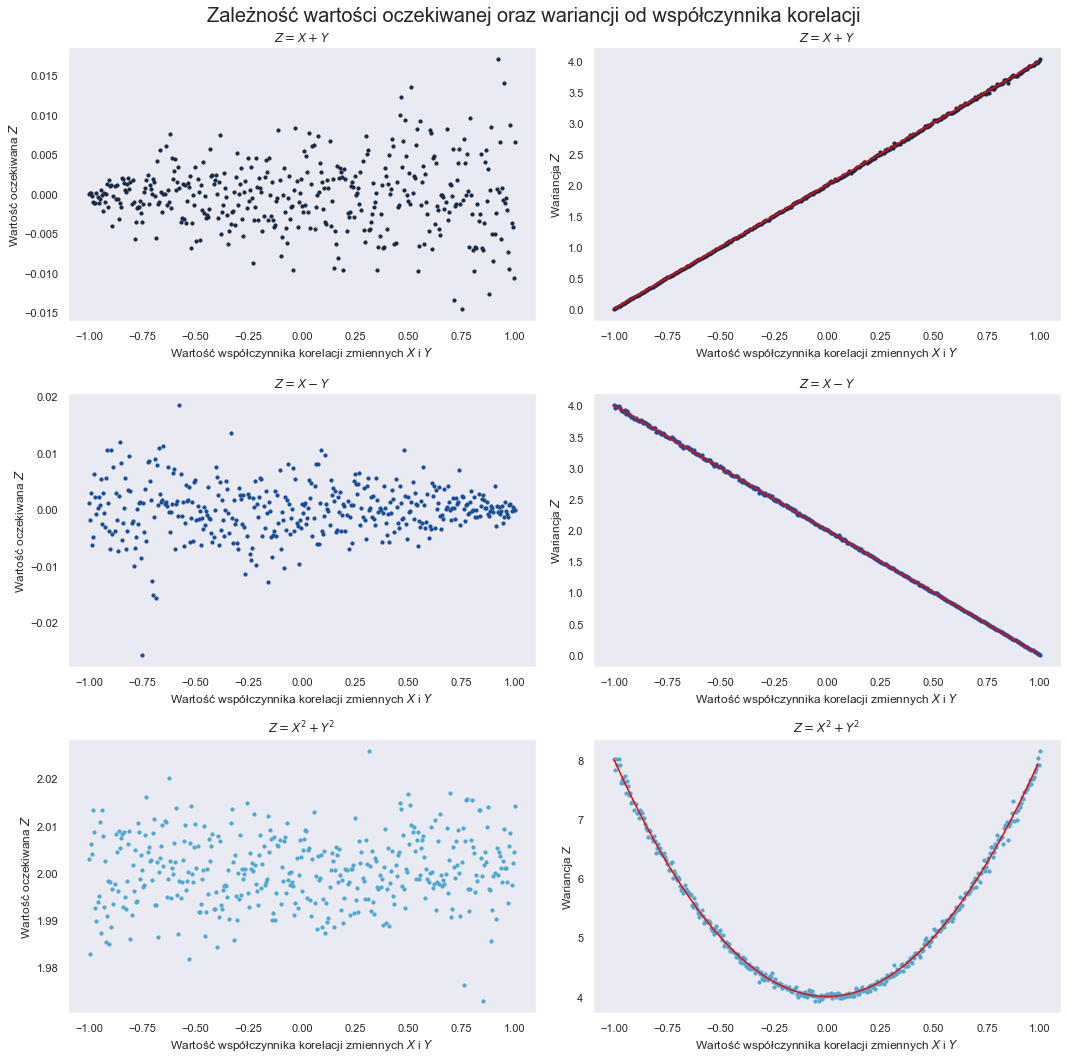

In [59]:
## Wykresy zależności wartości oczekiwanej i wariancji od współczynnika korelacji
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(wsp_korelacji, Z1_srednie, color="#182a47", s=10)
axs[0, 0].set_title("$Z = X + Y$")
axs[0, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[0, 0].set_ylabel("Wartość oczekiwana $Z$")
axs[0, 0].grid()

axs[1, 0].scatter(wsp_korelacji, Z2_srednie, color="#164d9d", s=10)
axs[1, 0].set_title("$Z = X - Y$")
axs[1, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[1, 0].set_ylabel("Wartość oczekiwana $Z$")
axs[1, 0].grid()

axs[2, 0].scatter(wsp_korelacji, Z3_srednie, color="#4ca9d3", s=10)
axs[2, 0].set_title("$Z = X^2 + Y^2$")
axs[2, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[2, 0].set_ylabel("Wartość oczekiwana $Z$")
axs[2, 0].grid()


axs[0, 1].scatter(wsp_korelacji, Z1_wariancje, color="#182a47", s=10)

f1 = lambda x: a1*x + b1
x1 = np.arange(-1,1,0.01)
y1 = f1(x1)
axs[0, 1].plot(x1, y1, color="red")

axs[0, 1].set_title("$Z = X + Y$")
axs[0, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[0, 1].set_ylabel("Wariancja $Z$")
axs[0, 1].grid()

axs[1, 1].scatter(wsp_korelacji, Z2_wariancje, color="#164d9d", s=10)

f2 = lambda x: a2*x + b2
x2 = np.arange(-1,1,0.01)
y2 = f2(x2)
axs[1, 1].plot(x2, y2, color="red")

axs[1, 1].set_title("$Z = X - Y$")
axs[1, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[1, 1].set_ylabel("Wariancja $Z$")
axs[1, 1].grid()

axs[2, 1].scatter(wsp_korelacji, Z3_wariancje, color="#4ca9d3", s=10)

f3 = lambda x: a3 * x**2 + b3*x + c3
x3 = np.arange(-1,1,0.01)
y3 = f3(x3)
axs[2, 1].plot(x3, y3, color="red")

axs[2, 1].set_title("$Z = X^2 + Y^2$")
axs[2, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[2, 1].set_ylabel("Wariancja Z")
axs[2, 1].grid()

fig.suptitle('Zależność wartości oczekiwanej oraz wariancji od współczynnika korelacji', fontsize=20)

plt.tight_layout()
plt.show()

Na podstawie wykresów możemy zauważyć, że korelacja między zmiennymi wpływa na rozkład sumy, różnicy oraz sumy ich kwadratów.

W szczególności, gdy korelacja między zmiennymi jest ujemna, to rozkład zmiennej będącej sumą jest bardziej skoncentrowany wokół wartości oczekiwanej. Natomiast gdy korelacja między zmiennymi jest dodatnia, to rozkład zmiennej będącej różnicą jest bardziej skoncentrowany wokół wartości oczekiwanej. Z kolei gdy korelacja między zmiennymi jest bliska zeru, to rozkład zmiennej będącej sumą kwadratów zmiennych jest bardziej skoncentrowany wokół wartości oczekiwanej.

Wyniki te są intuicyjne i wynikają z faktu, że gdy zmienne są skorelowane, to ich wartości są ze sobą powiązane. Dlatego dodając dwie zmienne ze zmienną korelacją ujemną, niejako równoważymy je wzajemnie, co prowadzi do zmniejszenia rozproszenia wynikowej zmiennej. Podobnie, odejmując dwie zmienne o dodatniej korelacji, również je równoważymy, co prowadzi do zmniejszenia rozproszenia. Zachowanie sumy kwadratów wynika z faktu, że w przypadku, gdy zmienne są nieskorelowane (korelacja wynosi 0), wartość oczekiwana sumy kwadratów zmiennych jest równa sumie kwadratów ich wartości oczekiwanych.

Poniżej przedstawiono wykresy zależności skośności oraz kurtozy od współczynnika korelacji.

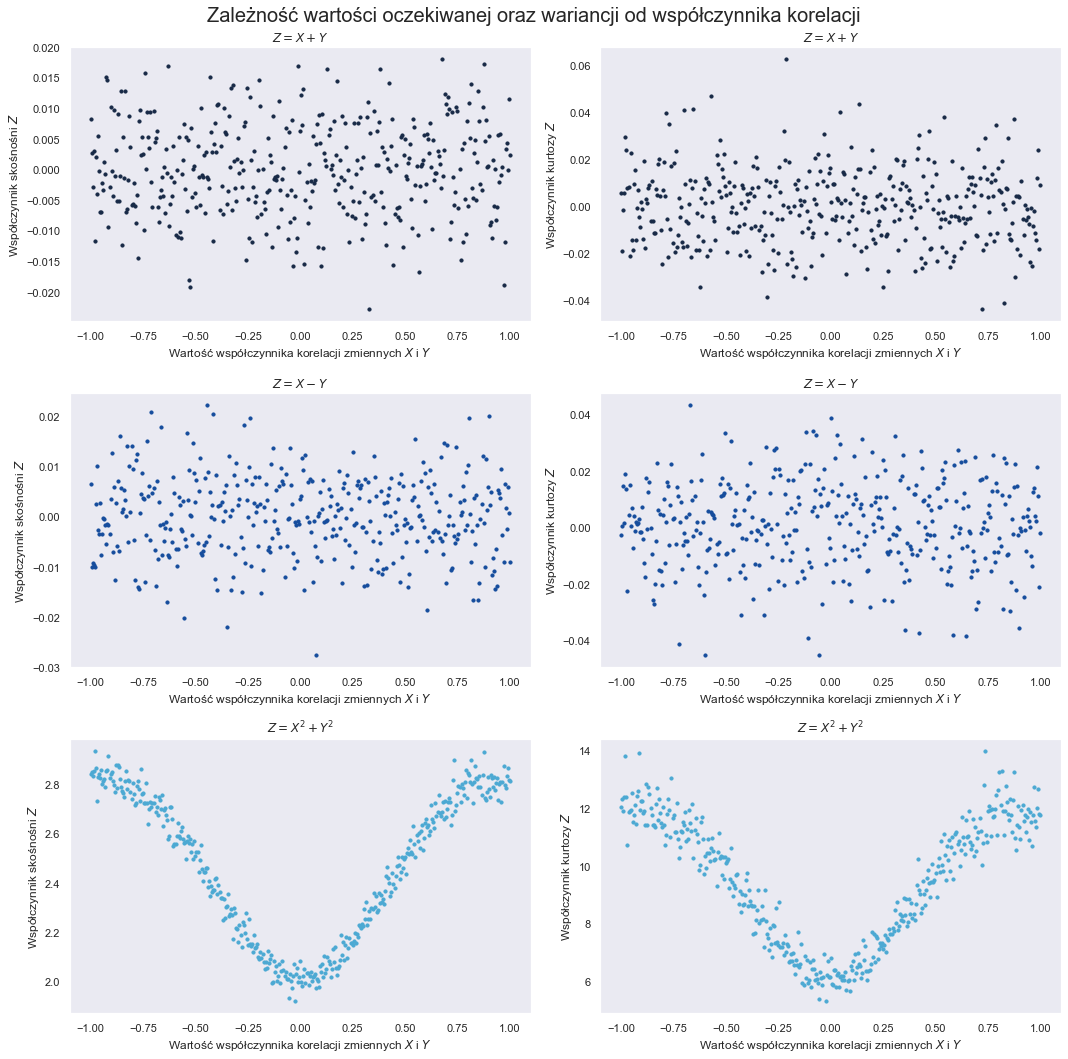

In [61]:
## Wykresy zależności skośności i kurtozy od współczynnika korelacji
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].scatter(wsp_korelacji, Z1_skosnosci, color="#182a47", s=10)
axs[0, 0].set_title("$Z = X + Y$")
axs[0, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[0, 0].set_ylabel("Współczynnik skośnośni $Z$")
axs[0, 0].grid()
axs[1, 0].scatter(wsp_korelacji, Z2_skosnosci, color="#164d9d", s=10)
axs[1, 0].set_title("$Z = X - Y$")
axs[1, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[1, 0].set_ylabel("Współczynnik skośnośni $Z$")
axs[1, 0].grid()
axs[2, 0].scatter(wsp_korelacji, Z3_skosnosci, color="#4ca9d3", s=10)
axs[2, 0].set_title("$Z = X^2 + Y^2$")
axs[2, 0].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[2, 0].set_ylabel("Współczynnik skośnośni $Z$")
axs[2, 0].grid()

axs[0, 1].scatter(wsp_korelacji, Z1_kurtozy, color="#182a47", s=10)
axs[0, 1].set_title("$Z = X + Y$")
axs[0, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[0, 1].set_ylabel("Współczynnik kurtozy $Z$")
axs[0, 1].grid()
axs[1, 1].scatter(wsp_korelacji, Z2_kurtozy, color="#164d9d", s=10)
axs[1, 1].set_title("$Z = X - Y$")
axs[1, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[1, 1].set_ylabel("Współczynnik kurtozy $Z$")
axs[1, 1].grid()
axs[2, 1].scatter(wsp_korelacji, Z3_kurtozy, color="#4ca9d3", s=10)
axs[2, 1].set_title("$Z = X^2 + Y^2$")
axs[2, 1].set_xlabel("Wartość współczynnika korelacji zmiennych $X$ i $Y$")
axs[2, 1].set_ylabel("Współczynnik kurtozy $Z$")
axs[2, 1].grid()

fig.suptitle('Zależność wartości oczekiwanej oraz wariancji od współczynnika korelacji', fontsize=20)

plt.tight_layout()
plt.show()

### Wnioski


Z powyższych wniosków wynika, że korelacja między zmiennymi ma istotny wpływ na rozkład sumy, różnicy oraz sumy kwadratów zmiennych.

Dla sumy zmiennych losowych wzrost korelacji prowadzi do zwiększenia wariancji, a dla różnicy zmiennych losowych prowadzi do zmniejszenia wariancji. Dla sumy kwadratów zmiennych losowych wzrost korelacji prowadzi do zwiększenia wariancji, a także zmniejszenia skośności i kurtozy.

Ogólnie rzecz biorąc, korelacja między zmiennymi jest ważnym narzędziem do analizy zależności między zmiennymi losowymi. Warto zwrócić uwagę na to, że korelacja nie implikuje przyczynowości i należy ją analizować w kontekście konkretnego problemu.